In [7]:
import os
from IPython.display import Image as ipy_image
from IPython.display import display

#from utils.demo_util import get_shape_comp_model, get_shape_comp_opt, make_dummy_batch
#from utils.qual_util import load_bert2vqsc_model, get_lang_prob, save_mesh_as_gif
from utils.qual_util import get_lang_prob, save_mesh_as_gif
from utils.util import seed_everything
from utils.util_3d import init_mesh_renderer, sdf_to_mesh
import os
from termcolor import colored, cprint
import torch
import utils.util as util
from tqdm.notebook import tqdm

from datasets.ys_shapeset import  ShapeNetZSets

from datasets.text2shape import  Text2Shape





import cv2
import numpy as np
import imageio
from PIL import Image
from einops import rearrange
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

from pytorch3d import structures

from utils.util_3d import sdf_to_mesh, render_mesh, rotate_mesh_360


from datasets.text2shape import  Text2Shape


%reload_ext autoreload
%autoreload 2

In [9]:
def create_model(opt):
    model = None

    if opt.model == 'pvqvae':
        # vqvae
        from models.pvqvae_model import PVQVAEModel
        model = PVQVAEModel()
    elif opt.model == 'rand_tf':
        # transformer
        from models.rand_tf_model import RandTransformerModel
        model = RandTransformerModel()
    elif opt.model == 'rand_tf_old':
        from models.rand_tf_model_old import RandTransformerModelOld
        model = RandTransformerModelOld()
    elif opt.model == 'seq_tf':
        # seq-transformer
        from models.seq_tf_model import SeqTransformerModel
        model = SeqTransformerModel()
    elif opt.model == 'bert2vq':
        from models.bert2vq_model import BERT2VQModel
        model = BERT2VQModel()
    elif opt.model == "bert2vqsc":
        from models.bert2vq_scmodel import BERT2VQSCModel
        model = BERT2VQSCModel()
    elif opt.model == 'resnet2vq':
        from models.resnet2vq_model import ResNet2VQModel
        model = ResNet2VQModel()
    elif opt.model == 'resnet2vox':
        from models.resnet2vox_model import ResNet2VoxModel
        model = ResNet2VoxModel()
    elif opt.model == 'resnet2sdf':
        from models.resnet2sdf_model import ResNet2SDFModel
        model = ResNet2SDFModel()
    elif opt.model == 'baseline_je':
        from models.baseline_je_model import LangJEModel
        model = LangJEModel()
    elif opt.model == 'img_je':
        from models.img_je_model import ImgJEModel
        model = ImgJEModel()
    else:
        raise ValueError("Model [%s] not recognized." % opt.model)

    model.initialize(opt)
    cprint("[*] Model has been created: %s" % model.name(), 'blue')
    if(opt.ckpt is not None):
        model.load_ckpt(opt.ckpt)
        print("MODEL LOADED")
    return model

def get_shape_comp_opt(gpu_id=0):
    opt = Opt()

    # args
    gpuid=[gpu_id]
    batch_size=1
    max_dataset_size=10000000

    name='test_transformer'

    # default args
    opt.serial_batches = False
    opt.nThreads = 4

    # important args
    opt.dataset_mode = 'shapenet_code'
    opt.seed = 111
    opt.isTrain = False
    opt.gpu_ids = gpuid
    opt.device = 'cuda:%s' % gpuid[0]
    opt.batch_size = batch_size
    opt.max_dataset_size = max_dataset_size

    opt.name = name

    #utils.util.seed_everything(opt.seed)
    opt.phase = 'test'
    return opt




def get_shape_comp_model(opt, model, ckpt):
    
    # load tf stuff
    opt.model=model
    opt.tf_cfg='configs/rand_tf_snet_code.yaml'
    opt.ckpt = ckpt
    
    # load vq stuff
    opt.vq_model='pvqvae'
    opt.vq_cfg='configs/pvqvae_snet.yaml'
    opt.vq_ckpt='../raw_dataset/checkpoints/vqvae.pth'
    
    ### opt.vq_dset='sdf_code' # original
    opt.vq_dset='snet'

    model = create_model(opt)
    print(f'[*] "{opt.model}" initialized.')
    model.load_ckpt(opt.ckpt)
        
    return model



In [10]:
opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.dataset_mode = "text2shape"

#new_checkpoint_path = "logs/valid-valid-with-fusion-rand_tf-owndataset-chair-LR1e-4-clean-with-ckpt/ckpt/rand_tf_epoch-latest.pth"
new_checkpoint_path_V1 = "../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth"
new_checkpoint_path_V2="../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_v2.pth"
new_checkpoint_path_V3 = "../raw_dataset/checkpoints_new/rand_tf_epoch_0_fusion_v3.pth"
new_checkpoint_path_V5 = "../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth"


# modelV0 = get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints/rand_tf_singles_best.pth")    
# modelV0.eval()

# modelV4 =  get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints_new/rand_tf_250_epochs_v4.pth")
# modelV4.eval()

#modelV1 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V1) 
#modelV1.eval()

# modelV2 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V2)
# modelV2.eval()

# modelV3 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V3)
# modelV3.eval()

modelV5 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V5)
modelV5.eval()



[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth


/rhome/streakfull/.cache/pypoetry/virtualenvs/adl4cv-I-Koul65-py3.8/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[*] Model has been created: Rand-Transformer-Model
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth
MODEL LOADED
[*] "rand_tf" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth


In [18]:
""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)


def load_bert2vqsc_model_v3(opt):
    from models.networks.bert2vq_sc import BERT2VQ
    
    net = BERT2VQ(opt)
    # bert2vq_ckpt = '/home/paritosh/Desktop/Capstone/clean-code/generative_transformers/logs/bert2vq-shapenet_lang-all-LR1e-4-cleanCode-langMode-/ckpt/bert2vq_epoch-145.pth'
    #bert2vq_ckpt = '../raw_dataset/checkpoints/bert2vq_epoch-latest.pth'
    #bert2vq_ckpt = "../raw_dataset/checkpoints_plz/bert2vq_v2.pth"
    #bert2vq_ckpt = "./logs/bert2vqsc-text2shape-seq-LR1e-4-new-bert-1/ckpt/bert2vq_epoch-latest.pth"
    bert2vq_ckpt = "./logs/bert2vqsc-text2shape-seq-LR1e-4-new-bert-2-prev_z_shape_input-try-2/ckpt/bert2vq_epoch-latest.pth"
    state_dict = torch.load(bert2vq_ckpt)
    net.load_state_dict(state_dict['bert2vq'])
    net.eval()
    net.to(opt.device)
    
    return net

def load_bert2vqsc_model_v5(opt):
    from models.networks.bert2vq_sc_v5 import BERT2VQ
    
    net = BERT2VQ(opt)
    # bert2vq_ckpt = '/home/paritosh/Desktop/Capstone/clean-code/generative_transformers/logs/bert2vq-shapenet_lang-all-LR1e-4-cleanCode-langMode-/ckpt/bert2vq_epoch-145.pth'
    #bert2vq_ckpt = '../raw_dataset/checkpoints/bert2vq_epoch-latest.pth'
    #bert2vq_ckpt = "../raw_dataset/checkpoints_plz/bert2vq_v2.pth"
    bert2vq_ckpt = "../raw_dataset/checkpoints_bert/bert2vq_eopch-latest_v5_2.pth"
    state_dict = torch.load(bert2vq_ckpt)
    net.load_state_dict(state_dict['bert2vq'])
    net.eval()
    net.to(opt.device)
    
    return net

def load_bert2vqsc_model_v4(opt):
    from models.networks.bert2vq_sc_v4 import BERT2VQ
    
    net = BERT2VQ(opt)
    # bert2vq_ckpt = '/home/paritosh/Desktop/Capstone/clean-code/generative_transformers/logs/bert2vq-shapenet_lang-all-LR1e-4-cleanCode-langMode-/ckpt/bert2vq_epoch-145.pth'
    #bert2vq_ckpt = '../raw_dataset/checkpoints/bert2vq_epoch-latest.pth'
    #bert2vq_ckpt = "../raw_dataset/checkpoints_plz/bert2vq_v2.pth"
    bert2vq_ckpt = "../raw_dataset/checkpoints_bert/bert2vq_epoch-latest_smoothL1Loss_v4_3.pth"
    state_dict = torch.load(bert2vq_ckpt)
    net.load_state_dict(state_dict['bert2vq'])
    net.eval()
    net.to(opt.device)
    
    return net

opt.mlp_layers = 3
opt.mlp_hidden = 1024
bert2vqV4 = load_bert2vqsc_model_v4(opt)
bert2vqV5 = load_bert2vqsc_model_v5(opt)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
with open("./test_samples_paper.txt") as file:
    sequences = [line.rstrip() for line in file]
sequences_clean = [0] * len(sequences)
for i in range(len(sequences)):
    seq = sequences[i]
    sequence = seq.split(",")
    sequences_clean[i] = sequence
sequences_clean[0]

['an office chair', 'with long back', 'without arms']

In [ ]:
# from copy import deepcopy
# import random
# import string
# sequences_random = deepcopy(sequences_clean)
# for i in range(len(sequence_random)):
#     sequence = sequences_random[i]
#     for j in range(len(sequence)):
#         current_text = sequence[j]
#         letters = string.ascii_lowercase
#         text = ''.join(random.choice(letters) for k in range(len(current_text)))
#         sequence[j] = text

# sequences_random

In [26]:
seed_everything(111)

description = "bertV5/transformerV5 passing output of transformer to bert model"
res_dir = 'logs/new-bert/bertV5-transformerV5/passingOutput'
if not os.path.exists(res_dir): os.makedirs(res_dir)

with open(f"{res_dir}/description.txt","w") as f:
    f.write(description)

gpu_id = 0
nimgs=6

class Opt:
    def __init__(self):
        self.name = 'opt'

  0%|                                                                          | 0/14 [00:00<?, ?it/s]

an office chair ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: an office chair
Full Text: an office chair
Saved: logs/new-bert/bertV5-transformerV5/differences_text/0-0-modelV5-an office chair.gif


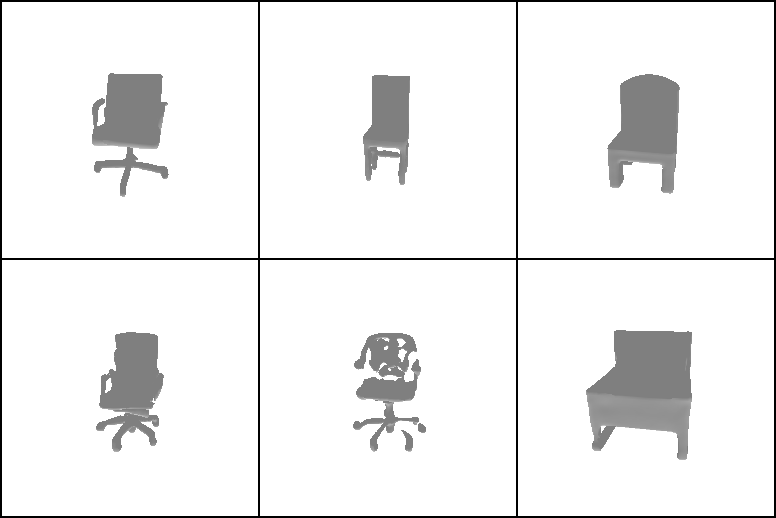

an office chair with long back ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: with long back
Full Text: an office chair with long back
Saved: logs/new-bert/bertV5-transformerV5/differences_text/0-1-modelV5-an office chair with long back.gif


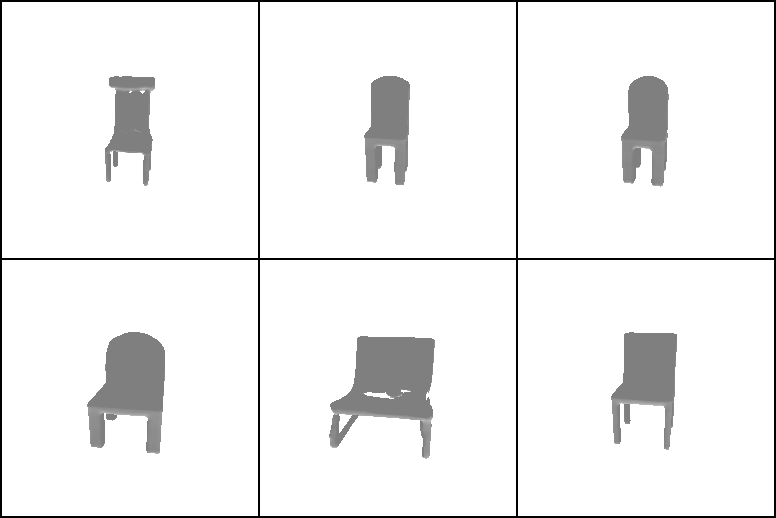

an office chair with long back without arms ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: without arms
Full Text: an office chair with long back without arms
Saved: logs/new-bert/bertV5-transformerV5/differences_text/0-2-modelV5-an office chair with long back without arms.gif


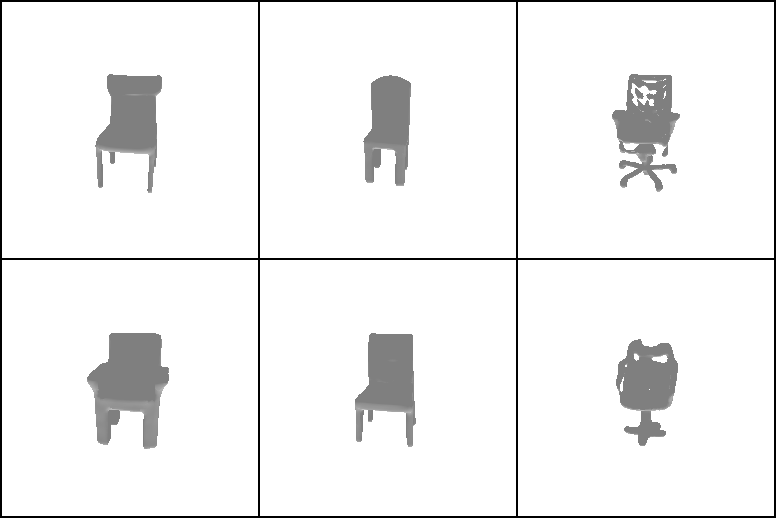

  7%|████▋                                                             | 1/14 [00:21<04:37, 21.33s/it]

a high bar seat ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: a high bar seat
Full Text: a high bar seat
Saved: logs/new-bert/bertV5-transformerV5/differences_text/1-0-modelV5-a high bar seat.gif


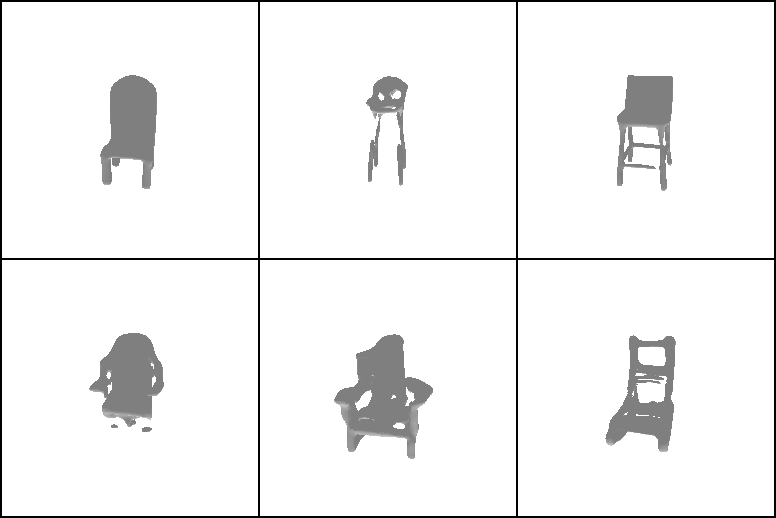

a high bar seat has a molded curved seat ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: has a molded curved seat
Full Text: a high bar seat has a molded curved seat
Saved: logs/new-bert/bertV5-transformerV5/differences_text/1-1-modelV5-a high bar seat has a molded curved seat.gif


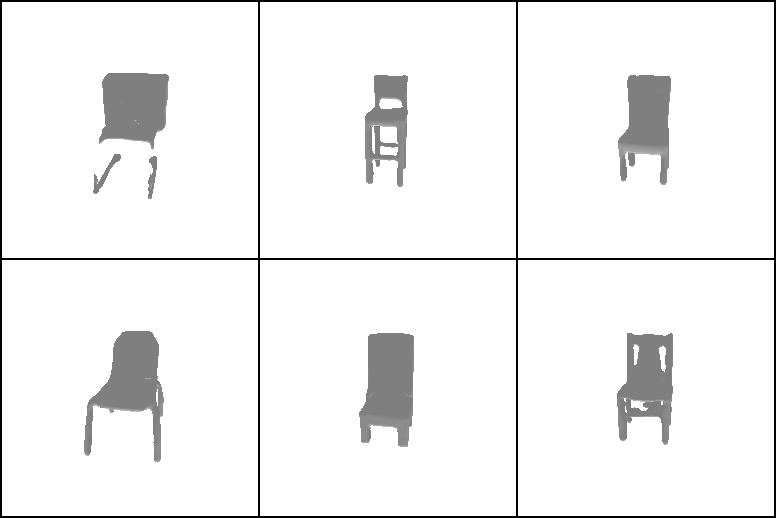

a high bar seat has a molded curved seat has a metal footrest and circular base ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: has a metal footrest and circular base
Full Text: a high bar seat has a molded curved seat has a metal footrest and circular base
Saved: logs/new-bert/bertV5-transformerV5/differences_text/1-2-modelV5-a high bar seat has a molded curved seat has a metal footrest and circular base.gif


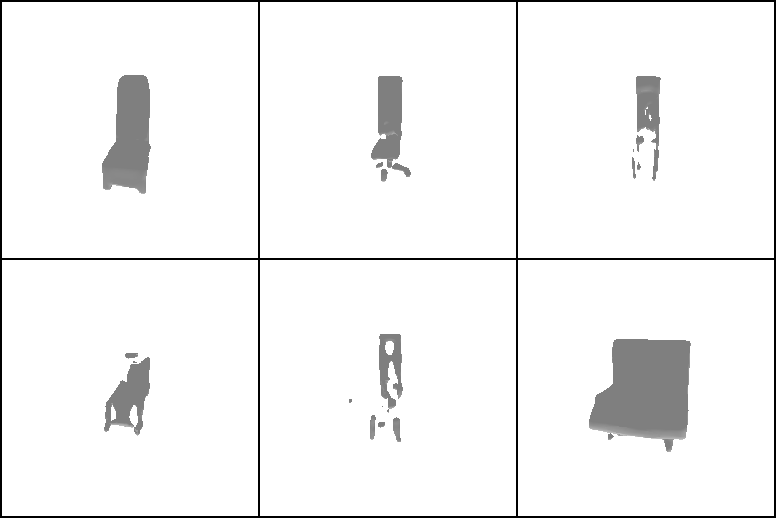

 14%|█████████▍                                                        | 2/14 [00:42<04:15, 21.28s/it]

a white metallic chair ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: a white metallic chair
Full Text: a white metallic chair
Saved: logs/new-bert/bertV5-transformerV5/differences_text/2-0-modelV5-a white metallic chair.gif


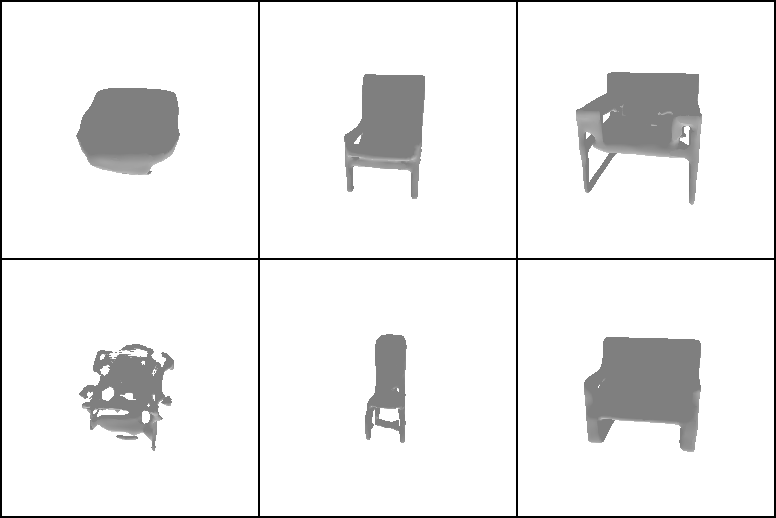

a white metallic chair with stand legs ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: with stand legs
Full Text: a white metallic chair with stand legs
Saved: logs/new-bert/bertV5-transformerV5/differences_text/2-1-modelV5-a white metallic chair with stand legs.gif


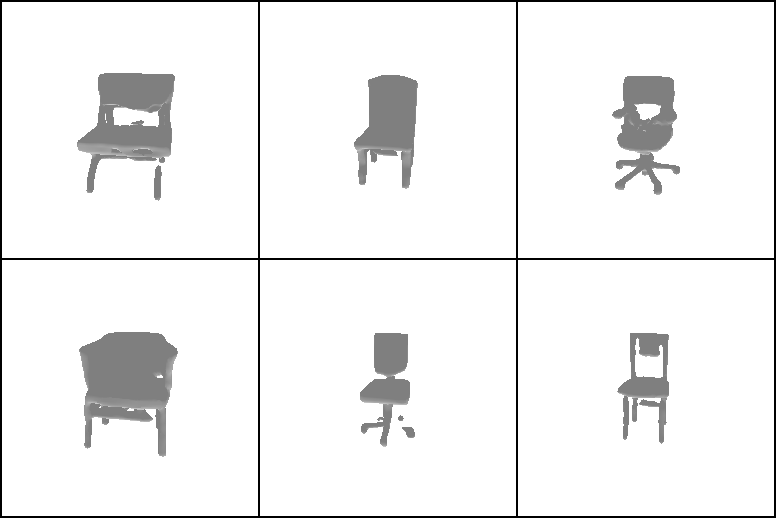

a white metallic chair with stand legs and wheels ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: and wheels
Full Text: a white metallic chair with stand legs and wheels
Saved: logs/new-bert/bertV5-transformerV5/differences_text/2-2-modelV5-a white metallic chair with stand legs and wheels.gif


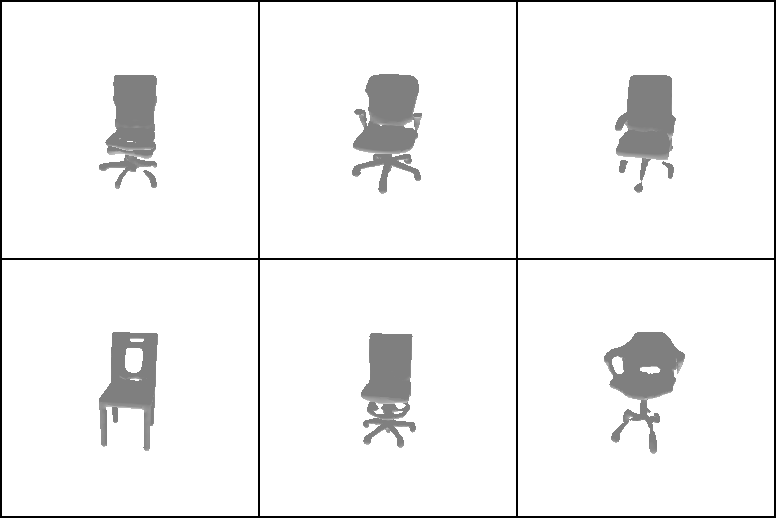

 21%|██████████████▏                                                   | 3/14 [01:04<03:54, 21.35s/it]

wooden chair ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: wooden chair
Full Text: wooden chair
Saved: logs/new-bert/bertV5-transformerV5/differences_text/3-0-modelV5-wooden chair.gif


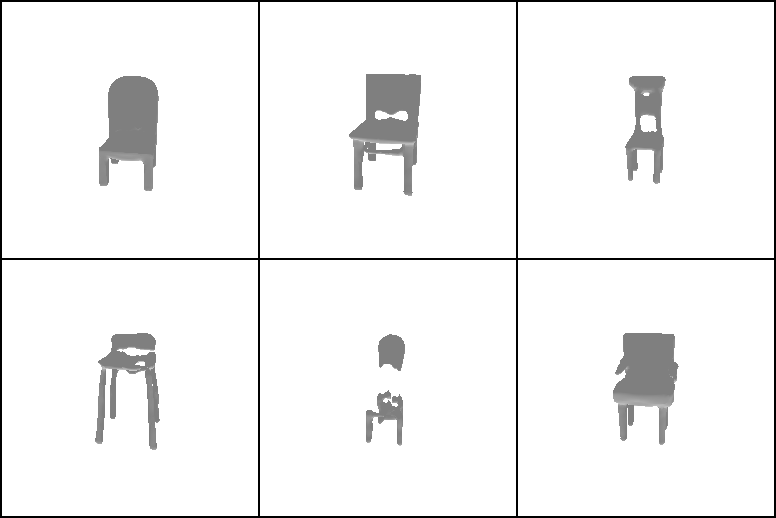

wooden chair with long back ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: with long back
Full Text: wooden chair with long back
Saved: logs/new-bert/bertV5-transformerV5/differences_text/3-1-modelV5-wooden chair with long back.gif


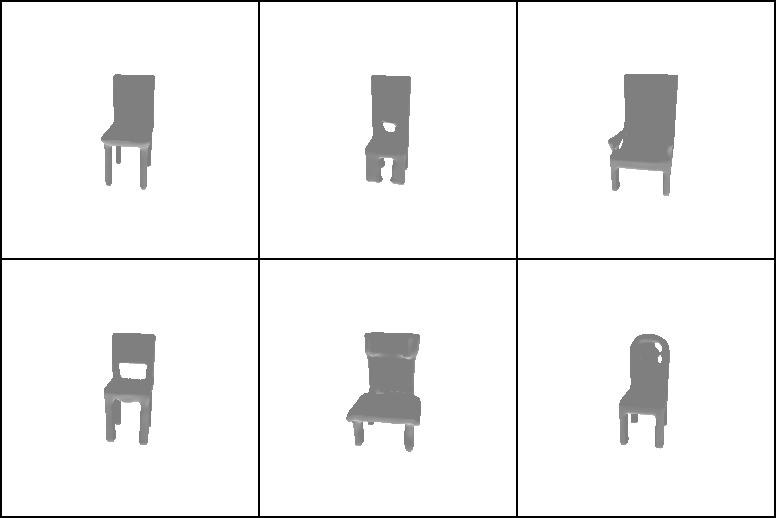

wooden chair with long back and 4 long legs attached at the corners and has no handles ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: and 4 long legs attached at the corners and has no handles
Full Text: wooden chair with long back and 4 long legs attached at the corners and has no handles
Saved: logs/new-bert/bertV5-transformerV5/differences_text/3-2-modelV5-wooden chair with long back and 4 long legs attached at the corners and has no handles.gif


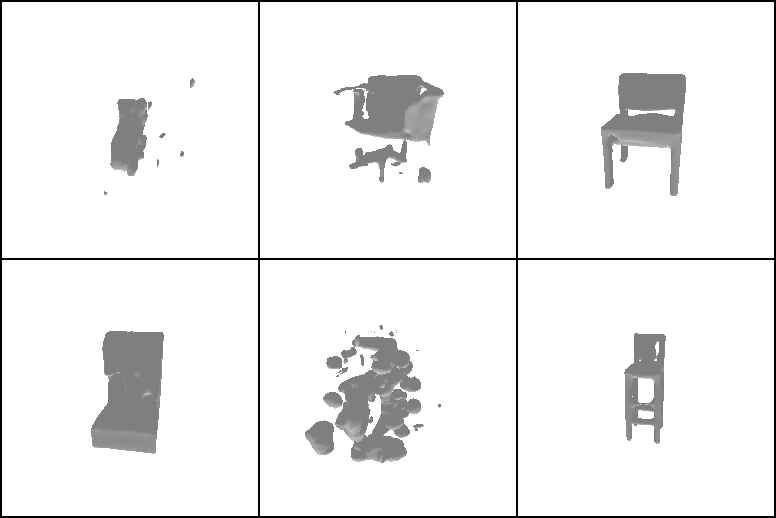

 29%|██████████████████▊                                               | 4/14 [01:25<03:33, 21.35s/it]

the armrests and frame are black ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: the armrests and frame are black
Full Text: the armrests and frame are black
Saved: logs/new-bert/bertV5-transformerV5/differences_text/4-0-modelV5-the armrests and frame are black.gif


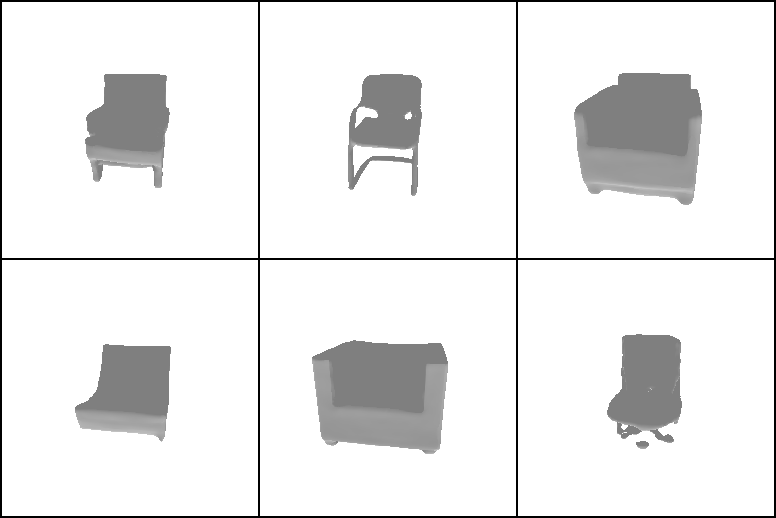

the armrests and frame are black and the chair slops slightly backward ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: and the chair slops slightly backward
Full Text: the armrests and frame are black and the chair slops slightly backward
Saved: logs/new-bert/bertV5-transformerV5/differences_text/4-1-modelV5-the armrests and frame are black and the chair slops slightly backward.gif


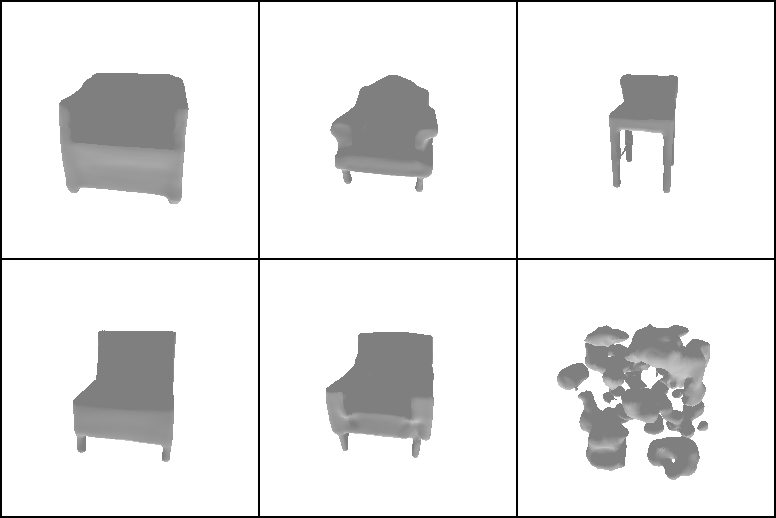

the armrests and frame are black and the chair slops slightly backward A gray sofa with a rectangular cushion and padding ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: A gray sofa with a rectangular cushion and padding
Full Text: the armrests and frame are black and the chair slops slightly backward A gray sofa with a rectangular cushion and padding
Saved: logs/new-bert/bertV5-transformerV5/differences_text/4-2-modelV5-the armrests and frame are black and the chair slops slightly backward A gray sofa with a rectangular cushion and padding.gif


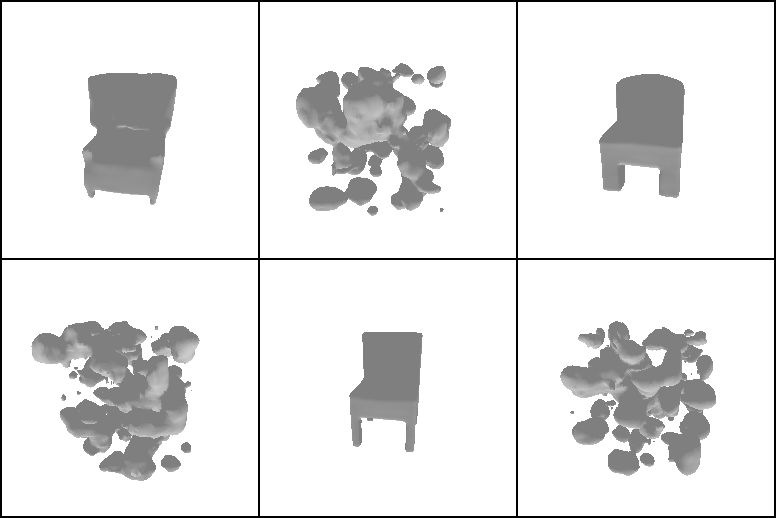

 36%|███████████████████████▌                                          | 5/14 [01:47<03:13, 21.49s/it]

A metal chair ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: A metal chair
Full Text: A metal chair
Saved: logs/new-bert/bertV5-transformerV5/differences_text/5-0-modelV5-A metal chair.gif


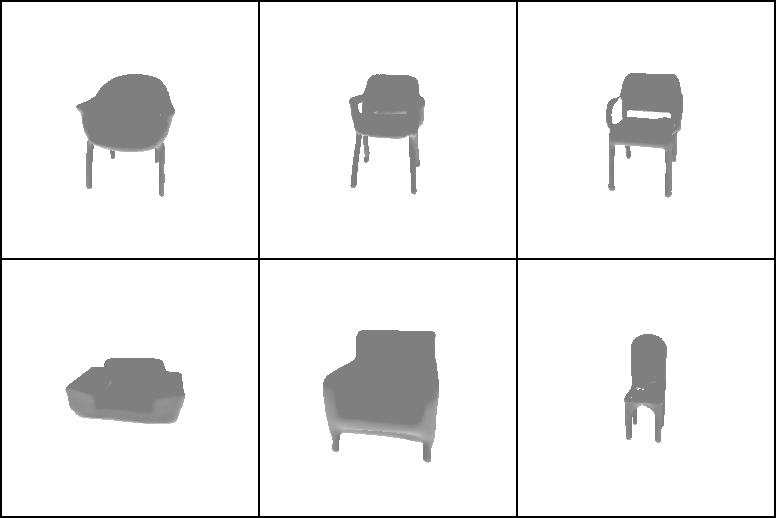

A metal chair with thin legs ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: with thin legs
Full Text: A metal chair with thin legs
Saved: logs/new-bert/bertV5-transformerV5/differences_text/5-1-modelV5-A metal chair with thin legs.gif


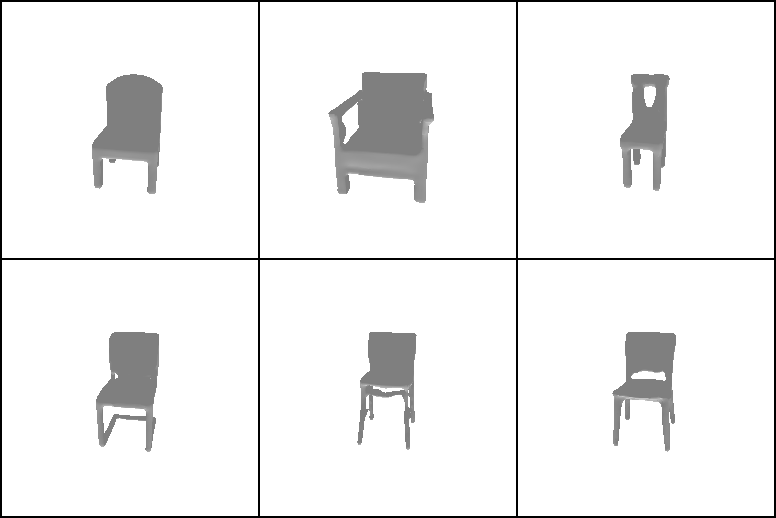

A metal chair with thin legs and two curved arms ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: and two curved arms
Full Text: A metal chair with thin legs and two curved arms
Saved: logs/new-bert/bertV5-transformerV5/differences_text/5-2-modelV5-A metal chair with thin legs and two curved arms.gif


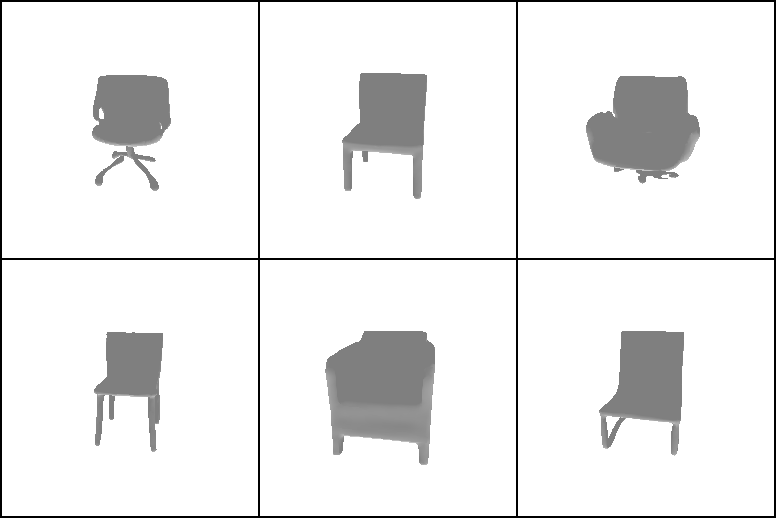

 43%|████████████████████████████▎                                     | 6/14 [02:08<02:52, 21.51s/it]

The seat has a space between the start of the seat and the start of the back itself ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: The seat has a space between the start of the seat and the start of the back itself
Full Text: The seat has a space between the start of the seat and the start of the back itself
Saved: logs/new-bert/bertV5-transformerV5/differences_text/6-0-modelV5-The seat has a space between the start of the seat and the start of the back itself.gif


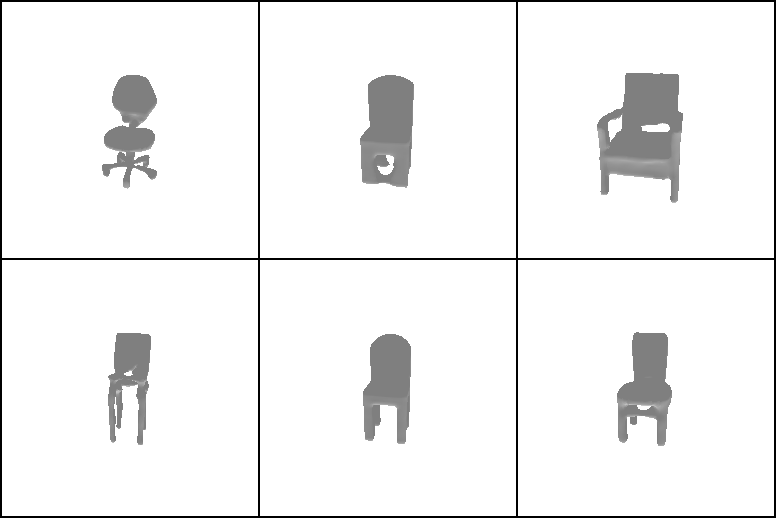

The seat has a space between the start of the seat and the start of the back itself modern and legless black and has a wedged back ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: modern and legless black and has a wedged back
Full Text: The seat has a space between the start of the seat and the start of the back itself modern and legless black and has a wedged back
Saved: logs/new-bert/bertV5-transformerV5/differences_text/6-1-modelV5-The seat has a space between the start of the seat and the start of the back itself modern and legless black and has a wedged back.gif


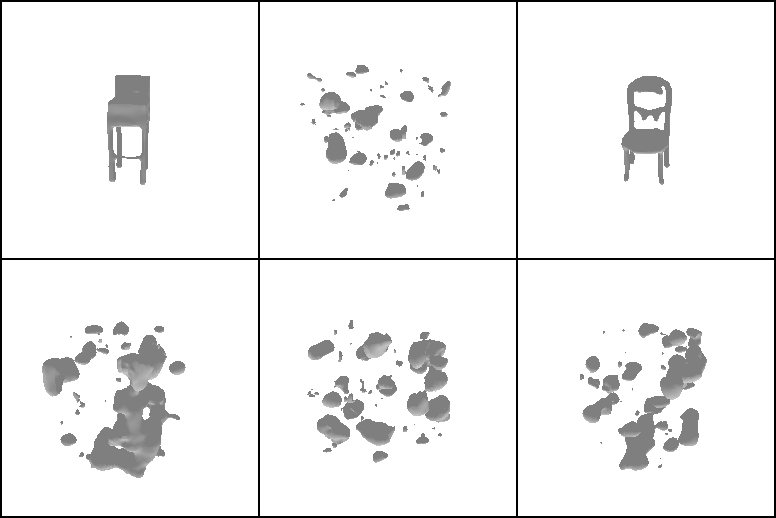

The seat has a space between the start of the seat and the start of the back itself modern and legless black and has a wedged back  single pedestal and seems to float in the air ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT:  single pedestal and seems to float in the air
Full Text: The seat has a space between the start of the seat and the start of the back itself modern and legless black and has a wedged back  single pedestal and seems to float in the air
Saved: logs/new-bert/bertV5-transformerV5/differences_text/6-2-modelV5-The seat has a space between the start of the seat and the start of the back itself modern and legless black and has a wedged back  single pedestal and seems to float in the air.gif


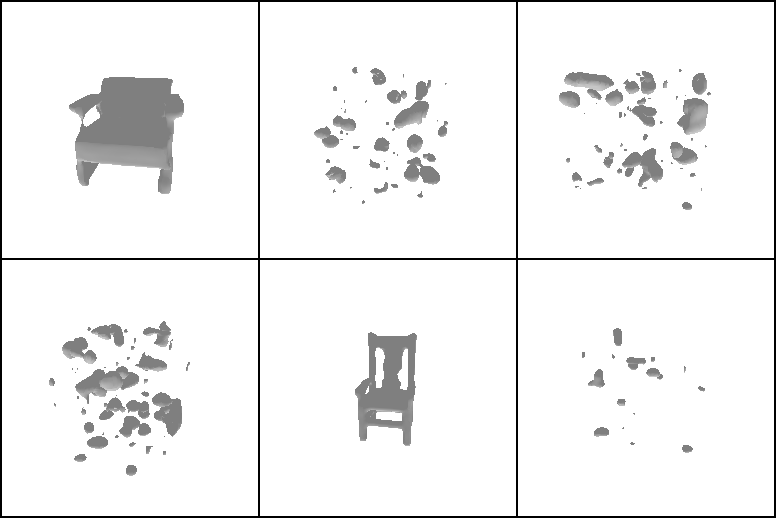

 50%|█████████████████████████████████                                 | 7/14 [02:30<02:30, 21.50s/it]

the back ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: the back
Full Text: the back
Saved: logs/new-bert/bertV5-transformerV5/differences_text/7-0-modelV5-the back.gif


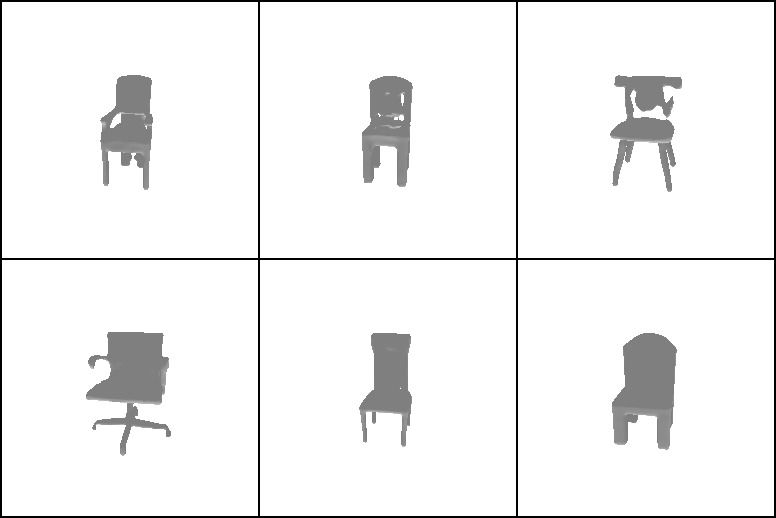

the back is rectrancle shaped ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: is rectrancle shaped
Full Text: the back is rectrancle shaped
Saved: logs/new-bert/bertV5-transformerV5/differences_text/7-1-modelV5-the back is rectrancle shaped.gif


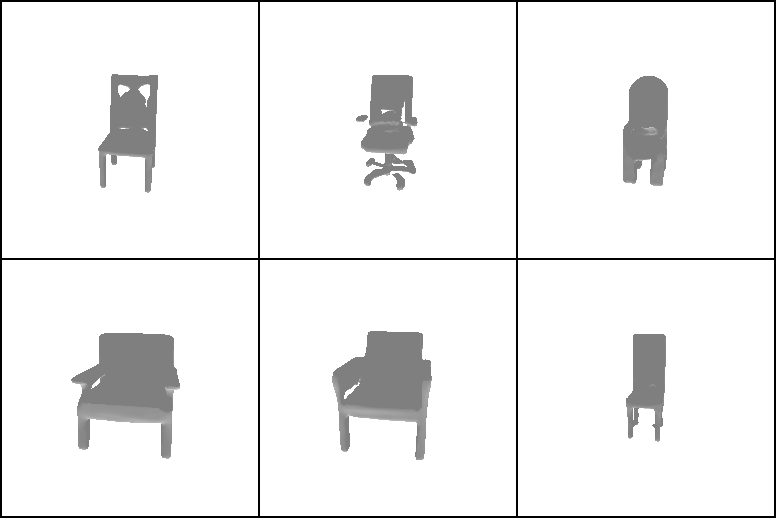

the back is rectrancle shaped while the hand rests are cylindrical in shape ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: while the hand rests are cylindrical in shape
Full Text: the back is rectrancle shaped while the hand rests are cylindrical in shape
Saved: logs/new-bert/bertV5-transformerV5/differences_text/7-2-modelV5-the back is rectrancle shaped while the hand rests are cylindrical in shape.gif


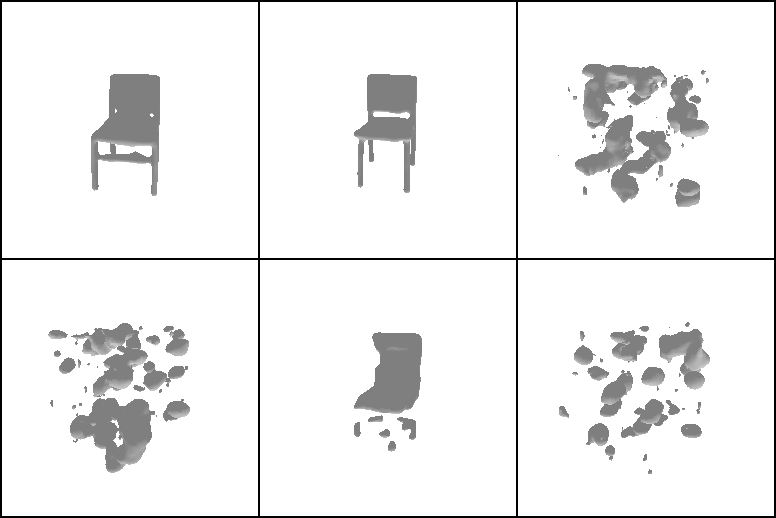

the back is rectrancle shaped while the hand rests are cylindrical in shape A cushion chair with ash colour ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: A cushion chair with ash colour
Full Text: the back is rectrancle shaped while the hand rests are cylindrical in shape A cushion chair with ash colour
Saved: logs/new-bert/bertV5-transformerV5/differences_text/7-3-modelV5-the back is rectrancle shaped while the hand rests are cylindrical in shape A cushion chair with ash colour.gif


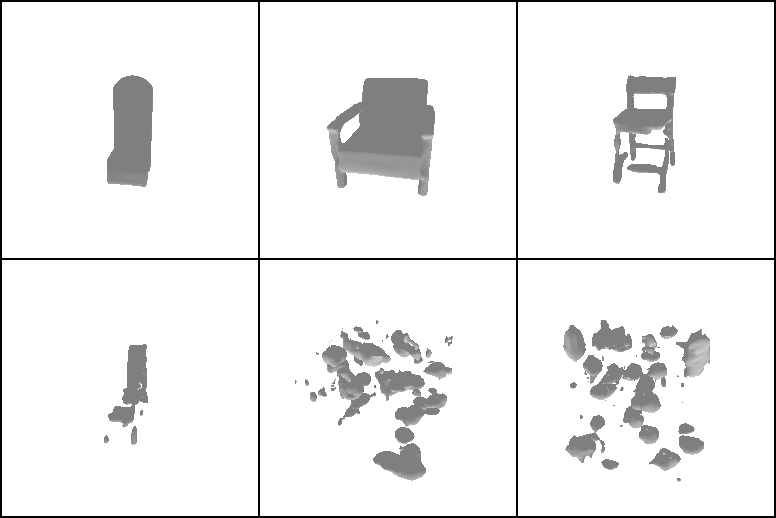

 57%|█████████████████████████████████████▋                            | 8/14 [02:58<02:22, 23.80s/it]

An orange fabric streteched deck chair ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: An orange fabric streteched deck chair
Full Text: An orange fabric streteched deck chair
Saved: logs/new-bert/bertV5-transformerV5/differences_text/8-0-modelV5-An orange fabric streteched deck chair.gif


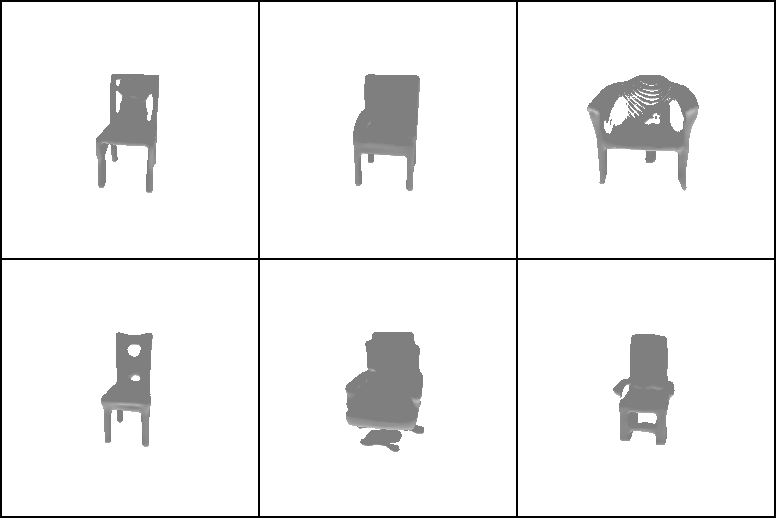

An orange fabric streteched deck chair with an s shaped aluminum framing for support ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: with an s shaped aluminum framing for support
Full Text: An orange fabric streteched deck chair with an s shaped aluminum framing for support
Saved: logs/new-bert/bertV5-transformerV5/differences_text/8-1-modelV5-An orange fabric streteched deck chair with an s shaped aluminum framing for support.gif


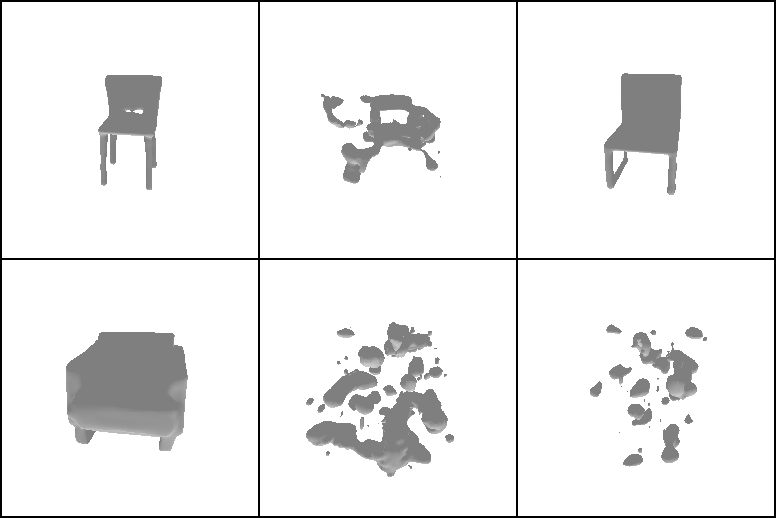

 64%|██████████████████████████████████████████▍                       | 9/14 [03:13<01:44, 20.85s/it]

the chair has short legs ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: the chair has short legs
Full Text: the chair has short legs
Saved: logs/new-bert/bertV5-transformerV5/differences_text/9-0-modelV5-the chair has short legs.gif


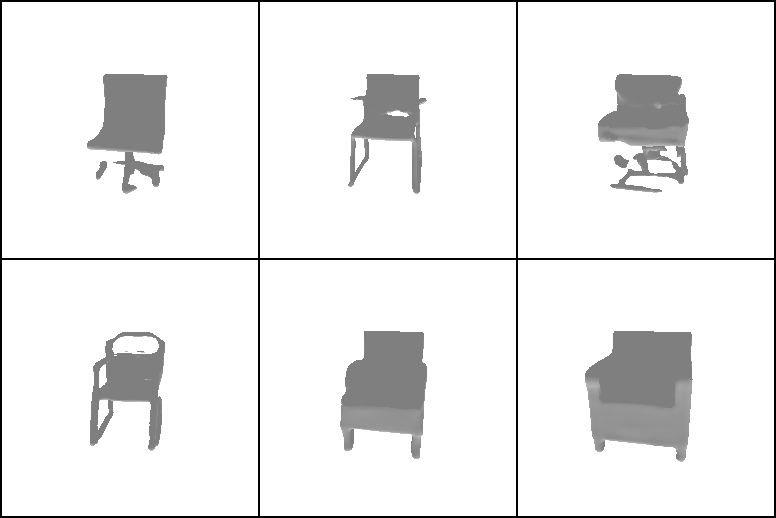

the chair has short legs a wooden chair polished yellow color with a reclining back ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: a wooden chair polished yellow color with a reclining back
Full Text: the chair has short legs a wooden chair polished yellow color with a reclining back
Saved: logs/new-bert/bertV5-transformerV5/differences_text/9-1-modelV5-the chair has short legs a wooden chair polished yellow color with a reclining back.gif


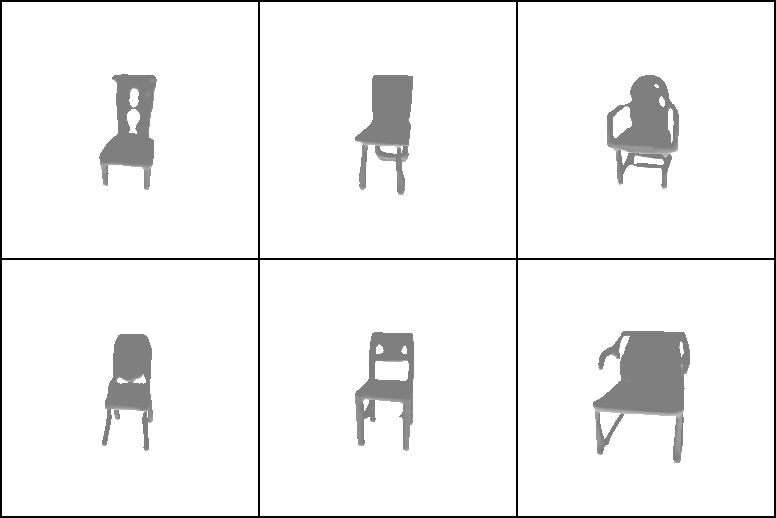

the chair has short legs a wooden chair polished yellow color with a reclining back and a square horizontal armrest on both the sides ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: and a square horizontal armrest on both the sides
Full Text: the chair has short legs a wooden chair polished yellow color with a reclining back and a square horizontal armrest on both the sides
Saved: logs/new-bert/bertV5-transformerV5/differences_text/9-2-modelV5-the chair has short legs a wooden chair polished yellow color with a reclining back and a square horizontal armrest on both the sides.gif


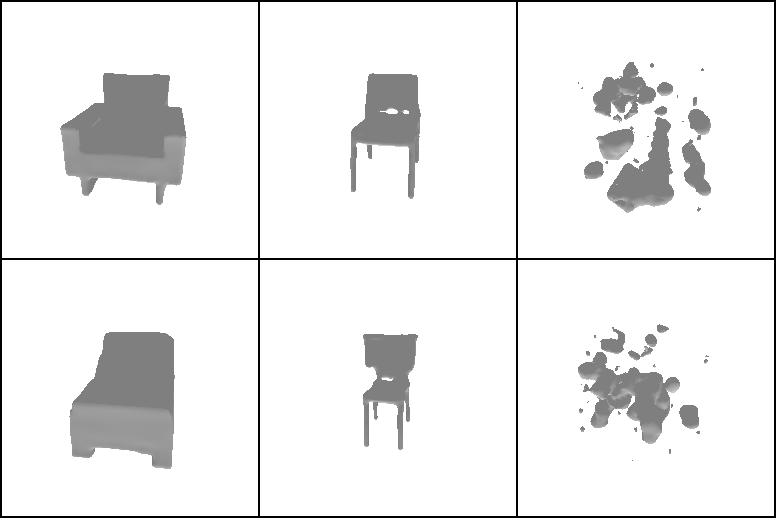

 71%|██████████████████████████████████████████████▍                  | 10/14 [03:34<01:24, 21.04s/it]

small metal office type chair ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: small metal office type chair
Full Text: small metal office type chair
Saved: logs/new-bert/bertV5-transformerV5/differences_text/10-0-modelV5-small metal office type chair.gif


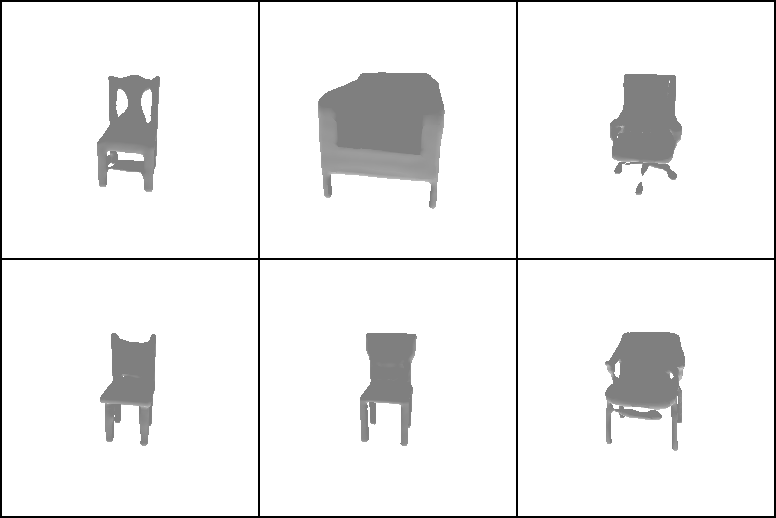

small metal office type chair  with no arms ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT:  with no arms
Full Text: small metal office type chair  with no arms
Saved: logs/new-bert/bertV5-transformerV5/differences_text/10-1-modelV5-small metal office type chair  with no arms.gif


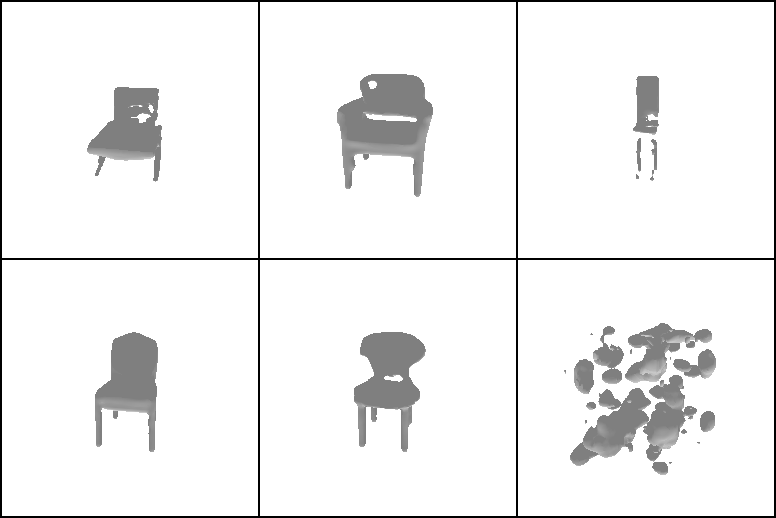

small metal office type chair  with no arms  the seat and back cushions are blue and it includes 4 wheels ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT:  the seat and back cushions are blue and it includes 4 wheels
Full Text: small metal office type chair  with no arms  the seat and back cushions are blue and it includes 4 wheels
Saved: logs/new-bert/bertV5-transformerV5/differences_text/10-2-modelV5-small metal office type chair  with no arms  the seat and back cushions are blue and it includes 4 wheels.gif


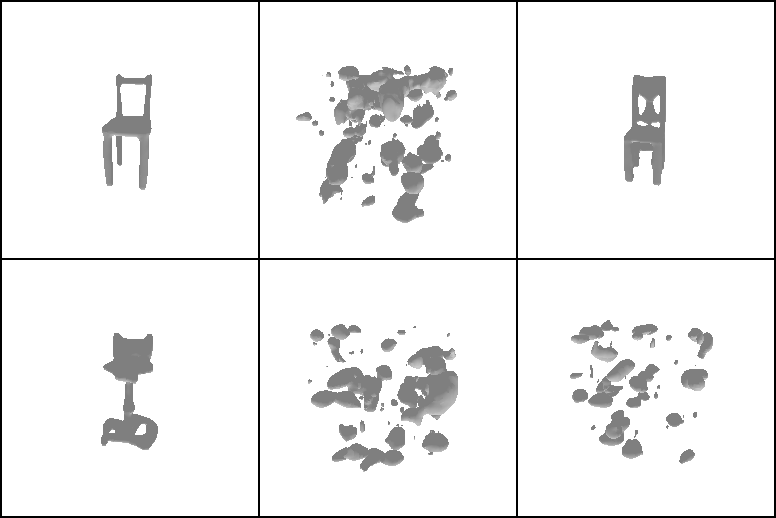

 79%|███████████████████████████████████████████████████              | 11/14 [03:56<01:03, 21.19s/it]

Office chair ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: Office chair
Full Text: Office chair
Saved: logs/new-bert/bertV5-transformerV5/differences_text/11-0-modelV5-Office chair.gif


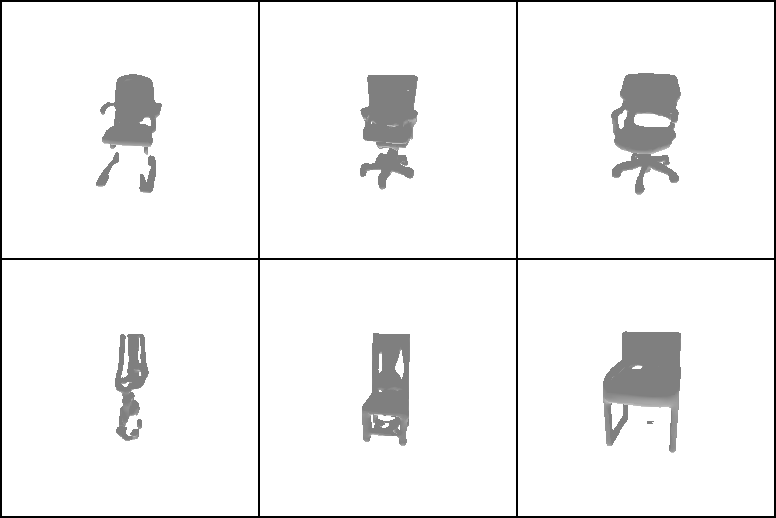

Office chair with arms ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: with arms
Full Text: Office chair with arms
Saved: logs/new-bert/bertV5-transformerV5/differences_text/11-1-modelV5-Office chair with arms.gif


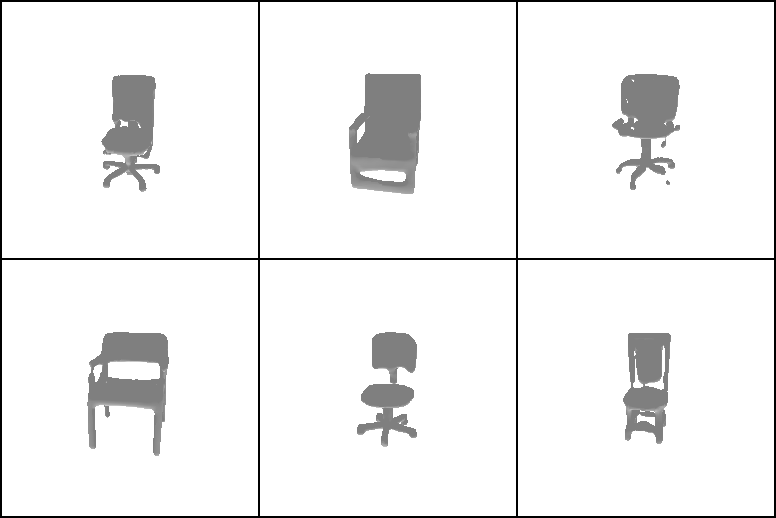

Office chair with arms  and legs that form a square on either side ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT:  and legs that form a square on either side
Full Text: Office chair with arms  and legs that form a square on either side
Saved: logs/new-bert/bertV5-transformerV5/differences_text/11-2-modelV5-Office chair with arms  and legs that form a square on either side.gif


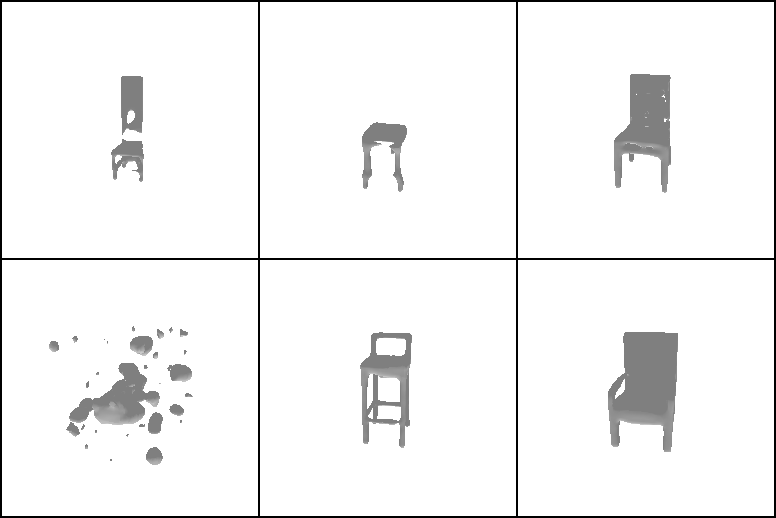

Office chair with arms  and legs that form a square on either side  and a support bar ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT:  and a support bar
Full Text: Office chair with arms  and legs that form a square on either side  and a support bar
Saved: logs/new-bert/bertV5-transformerV5/differences_text/11-3-modelV5-Office chair with arms  and legs that form a square on either side  and a support bar.gif


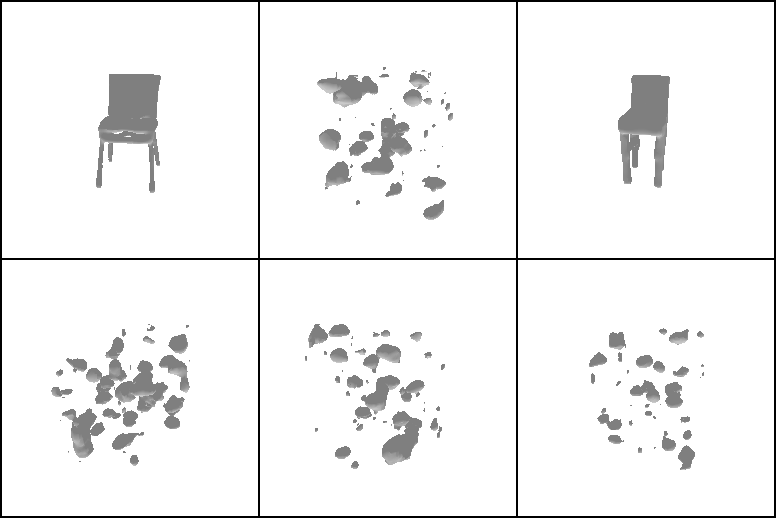

 86%|███████████████████████████████████████████████████████▋         | 12/14 [04:24<00:46, 23.46s/it]

wooden chair with legs ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: wooden chair with legs
Full Text: wooden chair with legs
Saved: logs/new-bert/bertV5-transformerV5/differences_text/12-0-modelV5-wooden chair with legs.gif


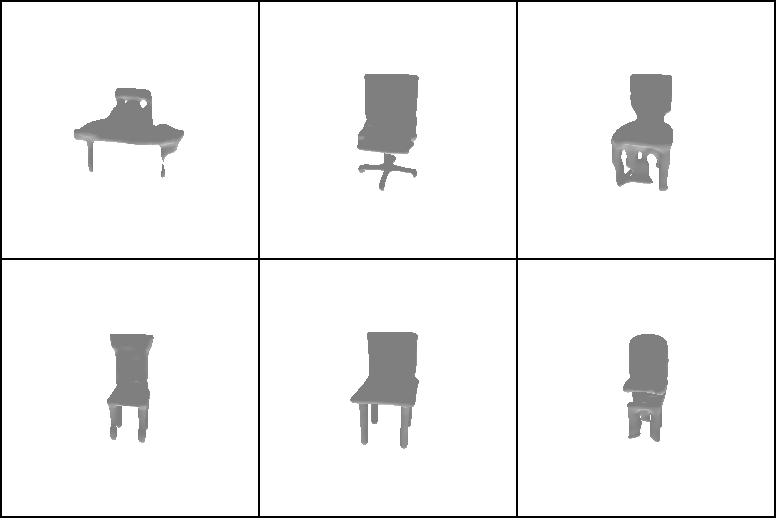

wooden chair with legs  in box shape ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT:  in box shape
Full Text: wooden chair with legs  in box shape
Saved: logs/new-bert/bertV5-transformerV5/differences_text/12-1-modelV5-wooden chair with legs  in box shape.gif


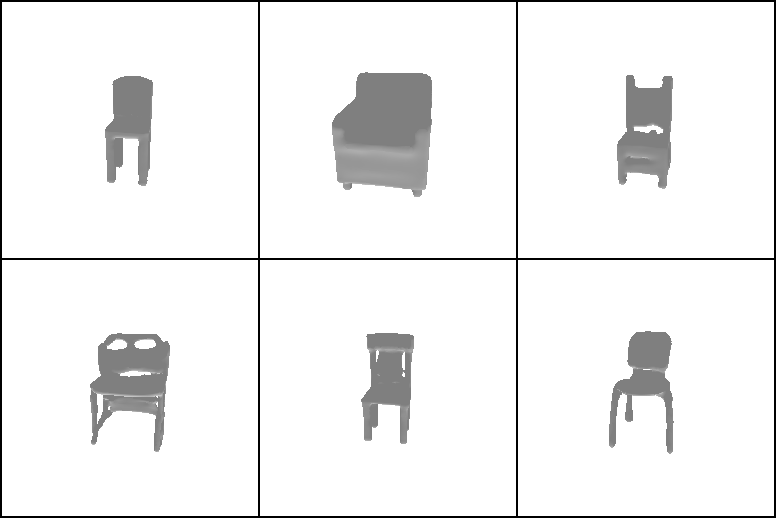

 93%|████████████████████████████████████████████████████████████▎    | 13/14 [04:39<00:20, 20.71s/it]

this chair has black color ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: this chair has black color
Full Text: this chair has black color
Saved: logs/new-bert/bertV5-transformerV5/differences_text/13-0-modelV5-this chair has black color.gif


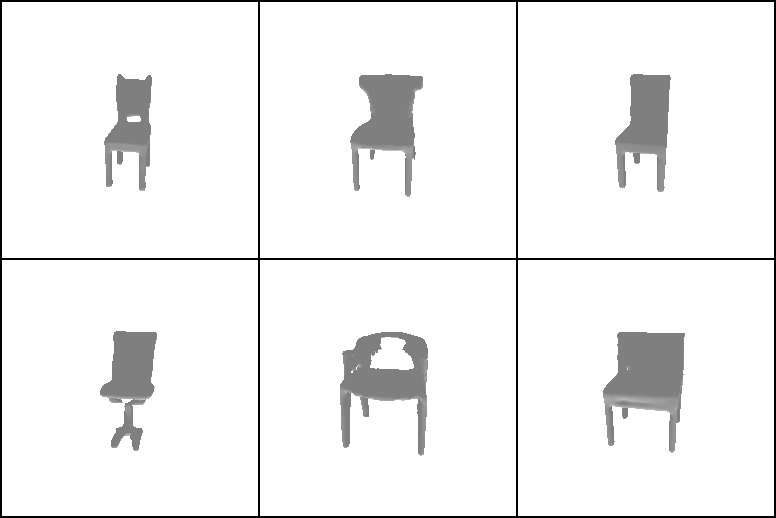

this chair has black color  single seats chair ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT:  single seats chair
Full Text: this chair has black color  single seats chair
Saved: logs/new-bert/bertV5-transformerV5/differences_text/13-1-modelV5-this chair has black color  single seats chair.gif


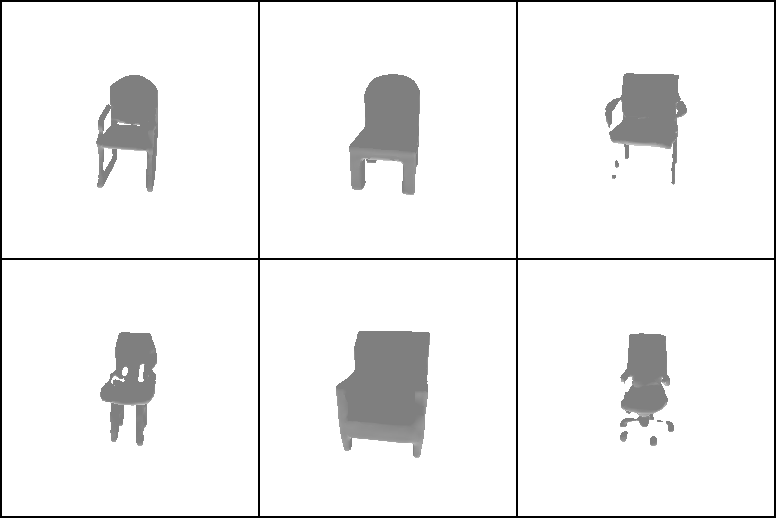

this chair has black color  single seats chair its made from metal ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

TEXT: its made from metal
Full Text: this chair has black color  single seats chair its made from metal
Saved: logs/new-bert/bertV5-transformerV5/differences_text/13-2-modelV5-this chair has black color  single seats chair its made from metal.gif


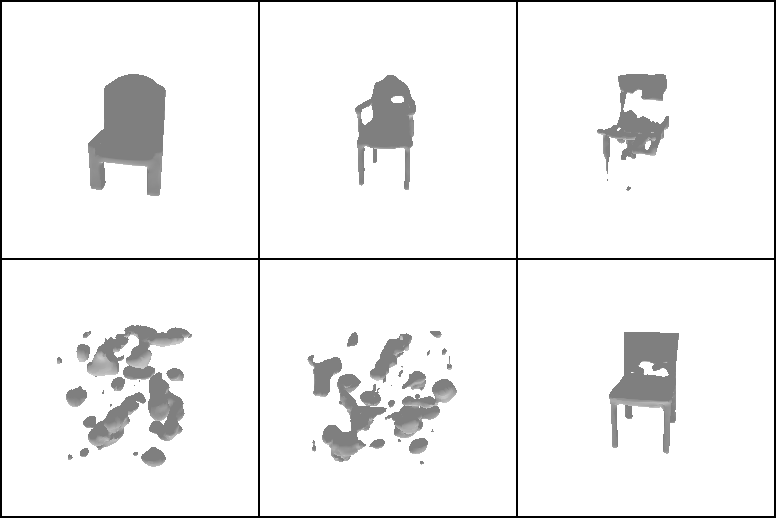

100%|█████████████████████████████████████████████████████████████████| 14/14 [05:00<00:00, 21.48s/it]


In [41]:
def get_lang_prob_recursive(bert_model,test_data, z1, opt=None):
    lang_logits = bert_model(test_data, z1)
    lang_logprob = torch.Softmax(lang_logits, dim=1) # compute the prob. of next ele
    # img_logprob = torch.sum(img_logprob, dim=1) # multiply the image priors
    lang_logprob = rearrange(lang_logprob, 'bs c d h w -> (d h w) bs c')
    return lang_logprob


model = modelV5
model_name = "modelV5"
bert2vq = bert2vqV5
import torch
from utils.qual_util import get_lang_prob_recursive, save_mesh_as_pics
from einops import rearrange


nimgs=6
for j in tqdm(range(len(sequences_clean))):
#for j in range(10):
    #text = sequence[j]
        sequence = sequences_clean[j]
        last_text = ""
        z1 = torch.full((1,8,8,8,512), 1/512).cuda()
        test_data = { }
        sampler = torch.distributions.categorical.Categorical(z1)
        codeix = sampler.sample()
    
        #z1  = z1.repeat_interleave(nimgs, dim=0)
        test_data["z_set"] = z1
        #test_data["z_set"] = shapeset[4]["z_set"].unsqueeze(0).repeat_interleave(nimgs, dim=0)
   
        test_data["idx"] = sampler.sample().repeat_interleave(nimgs, axis=0).cpu()
        test_data["z_q"] = z1
        z1 =  z1.repeat_interleave(nimgs, dim=0)
        print("======================================================================================================")
        for i in range(len(sequence)):
    #for i in range(10):
        #text = input("Enter text")
            text = sequence[i]
            all_text = last_text + text
            text_conditional = text
            lang_conditional_prob = get_lang_prob_recursive(bert2vq, [all_text]*nimgs, z1)
            z1_old = rearrange(z1, 'bs d h w c -> (d h w bs) c')
            z1 = rearrange(lang_conditional_prob, '(d h w) bs c -> bs d h w c', d=8, h=8, w=8)
            #import pdb;pdb.set_trace()
            print(all_text,"ALL TEXt")
            #import pdb;pdb.set_trace()
            #z1 = bert2vq([text] * nimgs, z1)
            #z1 = torch.clamp(z1, 1e-3)
            topk = 50
            #import pdb;pdb.set_trace()
            #test_data["z_set"] = z1.repeat_interleave(nimgs, dim=0)
            test_data["z_set"] = z1
            sampler = torch.distributions.categorical.Categorical(z1)
            #test_data["idx"] = torch.cat( [sampler.sample().cpu() for i in range(6)], dim=0)
            test_data["idx"] = torch.cat( [sampler.sample().cpu()], dim=0)
            #import pdb;pdb.set_trace()
            model.inference(test_data, topk=topk, prob=None, gen_order=None)
            #import pdb;pdb.set_trace()
            z1 = model.outp_concat.reshape((nimgs,8,8,8,512))
            #z1 = z1[0]
            gen_mesh = sdf_to_mesh(model.x_recon_tf)
    
            gen_gif_name = f'{res_dir}/{j}-{i}-{model_name}-{all_text}.gif'
            try:
                save_mesh_as_pics(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)
            except:
                import pdb;pdb.set_trace()
            last_text = all_text + " "
        
            print("TEXT:", text_conditional)
            print("Full Text:", all_text)
            print("Saved:", gen_gif_name)
            for name in [gen_gif_name]:
                display(ipy_image(name))